In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 22 09:50:38 2021

@author: poulomi
"""
'''
This project is to find anomaly in stock price using the concept of Autoencoders. We use the GE stock price as our dataset.
'''

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
np.random.seed(42)


In [2]:
#read the data and show it
from google.colab import files
uploaded =files.upload()
#reading the data set into a pandas dataframe
data = pd.read_csv("GE.csv")


Saving GE.csv to GE.csv


In [8]:
df = data[['Date', 'Close']]
df


,Date,Close
0,1962-01-02,0.748698
1,1962-01-03,0.741186
2,1962-01-04,0.732422
3,1962-01-05,0.713642
4,1962-01-08,0.712390
...,...,...
14901,2021-03-15,13.350000
14902,2021-03-16,13.150000
14903,2021-03-17,13.610000
14904,2021-03-18,13.250000


In [6]:
df['Date'] = pd.to_datetime(df['Date'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


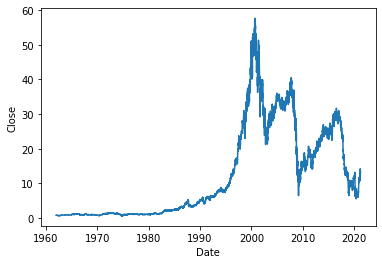

In [7]:
sns.lineplot(x=df['Date'], y=df['Close'])
plt.savefig("Data.png")


In [9]:
print('Start date is: ', df['Date'].min())
print('End date is: ', df['Date'].max())


Start date is:  1962-01-02
End date is:  2021-03-19


In [11]:
#dividing the data set into training and test sets, using location instead of 
train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']


In [12]:
#normalizing the data set since LSTM is sensitive to large values
#standardscaler standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

#now we have a model that we can use to transform our train and test data 
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
#As required by LSTM networks we need to reshape an input data into n samples X timesteps
seq_size = 60 # number of timesteps to look back, larger sequences might improve forecasting


In [14]:
def sequence(x,y,seq_size=1):
    x_values=[]
    y_values=[]
    
    for i in range(len(x) - seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

X_train, y_train = sequence(train[['Close']], train['Close'], seq_size)
X_test, y_test = sequence(test[['Close']], test['Close'], seq_size)


In [15]:
#Model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [18]:
#fitting the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/100
296/296 [==============================] - 33s 111ms/step - loss: 0.0164 - val_loss: 0.2324
Epoch 2/100
296/296 [==============================] - 33s 112ms/step - loss: 0.0154 - val_loss: 0.2575
Epoch 3/100
296/296 [==============================] - 33s 110ms/step - loss: 0.0155 - val_loss: 0.1774
Epoch 4/100
296/296 [==============================] - 33s 111ms/step - loss: 0.0155 - val_loss: 0.2608
Epoch 5/100
296/296 [==============================] - 33s 111ms/step - loss: 0.0160 - val_loss: 0.2048
Epoch 6/100
296/296 [==============================] - 33s 111ms/step - loss: 0.0156 - val_loss: 0.2545
Epoch 7/100
296/296 [==============================] - 33s 112ms/step - loss: 0.0156 - val_loss: 0.1910
Epoch 8/100
296/296 [==============================] - 33s 112ms/step - loss: 0.0153 - val_loss: 0.1971
Epoch 9/100
296/296 [==============================] - 33s 111ms/step - loss: 0.0155 - val_loss: 0.1646
Epoch 10/100
296/296 [==============================] - 33s 111m

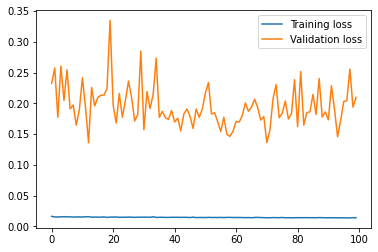

In [19]:
#plotting the losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.savefig("Loss.png")


(array([7.805e+03, 7.440e+02, 3.460e+02, 2.360e+02, 2.250e+02, 1.610e+02,
        1.300e+02, 1.410e+02, 9.500e+01, 7.500e+01, 6.500e+01, 4.800e+01,
        2.700e+01, 4.000e+01, 3.000e+01, 3.500e+01, 3.300e+01, 2.600e+01,
        2.500e+01, 3.600e+01, 2.300e+01, 2.500e+01, 2.100e+01, 1.900e+01,
        1.700e+01, 1.000e+01, 1.300e+01, 3.000e+00, 5.000e+00, 9.000e+00,
        3.000e+00, 8.000e+00, 5.000e+00, 6.000e+00, 8.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 4.000e+00]),
 array([9.37724266e-04, 2.55400114e-02, 5.01422986e-02, 7.47445858e-02,
        9.93468730e-02, 1.23949160e-01, 1.48551447e-01, 1.73153734e-01,
        1.97756022e-01, 2.22358309e-01, 2.46960596e-01, 2.71562883e-01,
        2.96165170e-01, 3.20767457e-01, 3.45369745e-01, 3.69972032e-01,
        3.94574319e-01, 4.19176606e-01, 4.43778893e-01, 4.68381181e-01,
        4.92983468e-01, 5.17585755e-01, 5.42188042e-01, 5.66790329e-01,
        5.91392616e-01, 6.15994904e-01, 6.40597191e-01, 6.65199478e-01

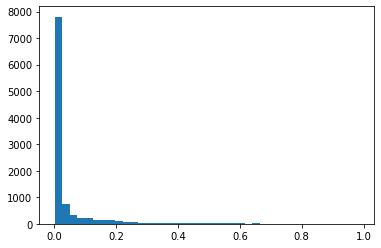

In [21]:
#Anomaly is detected where the reconstruction error is large
#we can define a value beyond which we call it an anomaly
#let's look at MAE (mean absolute error) in training prediction
pred_train = model.predict(X_train)
train_mae = np.mean(np.abs(pred_train-X_train), axis=1)
plt.hist(train_mae, bins=40)



(array([269., 728., 561., 591., 444., 380., 288., 220., 182., 114.,  88.,
         63.,  64.,  67.,  50.,  28.,  19.,  19.,  10.,  12.,  10.,  10.,
          7.,   5.,   9.,   2.,   5.,   5.,   4.,   3.,   7.,   3.,   0.,
          1.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([0.01671798, 0.03377228, 0.05082658, 0.06788088, 0.08493519,
        0.10198949, 0.11904379, 0.13609809, 0.15315239, 0.17020669,
        0.18726099, 0.20431529, 0.2213696 , 0.2384239 , 0.2554782 ,
        0.2725325 , 0.2895868 , 0.3066411 , 0.3236954 , 0.3407497 ,
        0.35780401, 0.37485831, 0.39191261, 0.40896691, 0.42602121,
        0.44307551, 0.46012981, 0.47718411, 0.49423842, 0.51129272,
        0.52834702, 0.54540132, 0.56245562, 0.57950992, 0.59656422,
        0.61361852, 0.63067283, 0.64772713, 0.66478143, 0.68183573,
        0.69889003]),
 <a list of 40 Patch objects>)

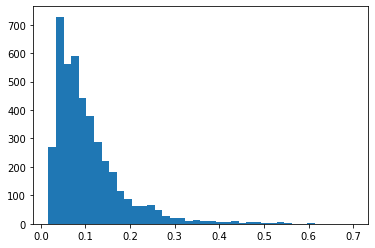

In [23]:
#error prediction on test data
pred_test = model.predict(X_test)
test_mae = np.mean(np.abs(pred_test-X_test), axis=1)
plt.hist(test_mae, bins=40)


In [31]:
max_train_mae = 0.38 # choosing the threshold value, thus beyond 0.38 it is anomaly

#Gathering all details in a dataframe to plot easily
anomaly = pd.DataFrame(test[seq_size:])
anomaly['test_mae'] = test_mae
anomaly['max_train_mae'] = max_train_mae
anomaly['anomaly'] = anomaly['test_mae'] > anomaly['max_train_mae']
anomaly['Close'] = test[seq_size:]['Close']


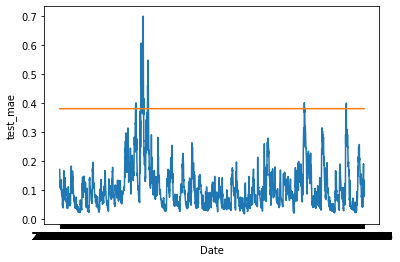

In [32]:
#plotting test_mae vs max_train_mae
sns.lineplot(x = anomaly['Date'], y = anomaly['test_mae'])
sns.lineplot(x = anomaly['Date'], y = anomaly['max_train_mae'])

actual_anomalies = anomaly.loc[anomaly['anomaly'] == True]


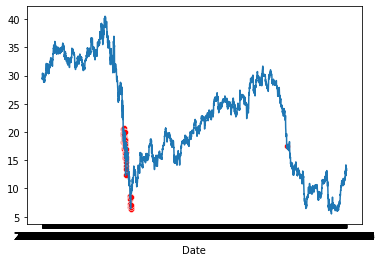

In [30]:
#plotting the actual anomalies, here as red dots
sns.lineplot(x=anomaly['Date'], y=scaler.inverse_transform(anomaly['Close']))
sns.scatterplot(x=actual_anomalies['Date'], y=scaler.inverse_transform(actual_anomalies['Close']), color='r')
#plt.savefig("Final output.png")
